<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Decoder_Wav2vec%2BKenLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torchaudio
!pip install transformers

In [2]:
!pip install https://github.com/kpu/kenlm/archive/master.zip

     |████████████████████████████████| 542 kB 937 kB/s 
  Created wheel for kenlm: filename=kenlm-0.0.0-cp37-cp37m-linux_x86_64.whl size=2335397 sha256=2a68e15debbbcce56b40144a0e618643ede71bfdeb3d7b08c818c16696d3b8ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-yglxjuv6/wheels/3d/aa/02/7b4a2eab5d7a2a9391bd9680dbad6270808a147bc3b7047e4e
Successfully built kenlm


In [3]:
%%capture
!pip install pyctcdecode

In [4]:
import os
import torch
import numpy as np

import IPython
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [22, 6]

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

from pyctcdecode import build_ctcdecoder

torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


In [5]:
SPEECH_FILE = "/content/drive/MyDrive/Wav2Vec/data/audio_paulo.wav"

# Metadata and wave plot

AudioMetaData(sample_rate=48000, num_frames=143040, num_channels=1, bits_per_sample=16, encoding=PCM_S)


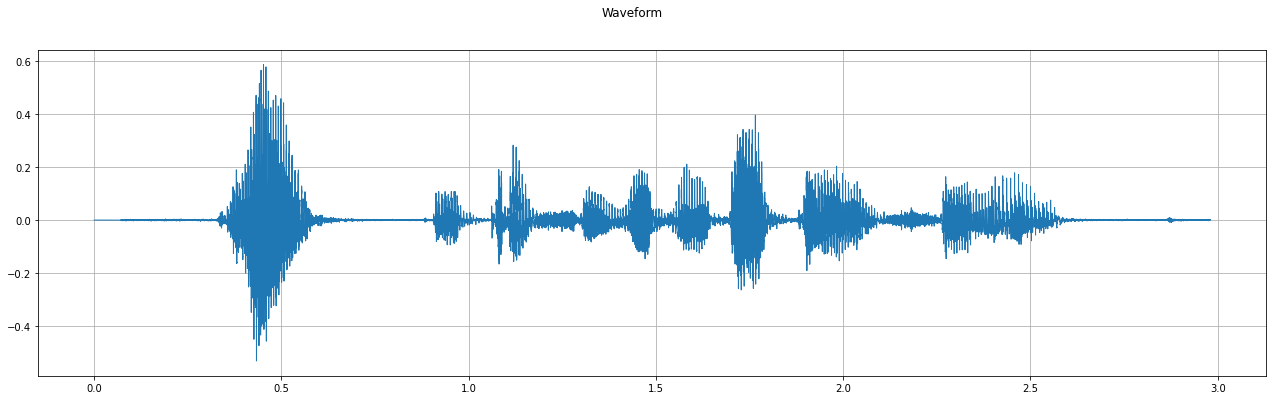

In [6]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

# - - - -

metadata = torchaudio.info(SPEECH_FILE)
print(metadata)

waveform, sample_rate = torchaudio.load(SPEECH_FILE)
plot_waveform(waveform, sample_rate)

IPython.display.Audio(SPEECH_FILE)

# Predict

In [7]:
model_name = 'lgris/wav2vec2-xls-r-pt-cv7-from-bp400h'
model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

Downloading:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/260 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [15]:
resampler = torchaudio.transforms.Resample(orig_freq=48_000, new_freq=16_000)

waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = resampler.forward(waveform.squeeze(0)).numpy()

features = processor(waveform, sampling_rate=16_000, padding=False, return_tensors="pt")

input_values = features.input_values

with torch.no_grad():
    logits = model(input_values)['logits']

print(f'logits shape: {logits.shape}\n')
pred_ids = torch.argmax(logits, dim=-1)

print(f'pred_ids shape: {pred_ids.shape}\n')

predicted = processor.batch_decode(pred_ids)
predicted = [pred.lower() for pred in predicted]
print(f'\nTranscription:\n\t{predicted[0]}\n')

logits shape: torch.Size([1, 148, 44])

pred_ids shape: torch.Size([1, 148])


Transcription:
	oi eu preciso de um cartão adicional



# back to slide

In [16]:
processor.tokenizer.get_vocab()

{'-': 35,
 '</s>': 2,
 '<pad>': 0,
 '<s>': 1,
 '<unk>': 3,
 'a': 5,
 'b': 24,
 'c': 16,
 'd': 13,
 'e': 6,
 'f': 22,
 'g': 21,
 'h': 23,
 'i': 10,
 'j': 30,
 'k': 41,
 'l': 17,
 'm': 12,
 'n': 11,
 'o': 7,
 'p': 18,
 'q': 20,
 'r': 9,
 's': 8,
 't': 14,
 'u': 15,
 'v': 19,
 'w': 43,
 'x': 33,
 'y': 42,
 'z': 29,
 '|': 4,
 'à': 38,
 'á': 28,
 'â': 40,
 'ã': 25,
 'ç': 27,
 'é': 26,
 'ê': 32,
 'í': 31,
 'ó': 34,
 'ô': 39,
 'õ': 36,
 'ú': 37}

In [9]:
pred_ids

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  7,  0,  0,  0,  0,  0,  0, 10,  0,  4,  4,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0, 15,  4,  4,  0,  0, 18,
          0,  9,  9,  6,  0,  0,  0,  0,  0, 16,  0, 10,  0,  0,  0,  8,  0,  7,
          0,  4,  4,  4, 13,  6,  4,  4, 15, 12,  4,  4,  0, 16,  0,  5,  0,  9,
          0,  0,  0, 14,  0, 25,  7,  7,  0,  4,  4,  0,  5,  0,  0, 13,  0, 10,
          0,  0,  0, 16,  0, 10,  0,  7,  0,  0, 11,  0,  5,  0,  0,  0,  0, 17,
          0,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]])

In [10]:
outs = processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist())

outs = ['' if elel =='<pad>' else elel for elel in outs]
print(outs)
print('-'.join(outs))

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'o', '', '', '', '', '', '', 'i', '', '|', '|', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'e', '', 'u', '|', '|', '', '', 'p', '', 'r', 'r', 'e', '', '', '', '', '', 'c', '', 'i', '', '', '', 's', '', 'o', '', '|', '|', '|', 'd', 'e', '|', '|', 'u', 'm', '|', '|', '', 'c', '', 'a', '', 'r', '', '', '', 't', '', 'ã', 'o', 'o', '', '|', '|', '', 'a', '', '', 'd', '', 'i', '', '', '', 'c', '', 'i', '', 'o', '', '', 'n', '', 'a', '', '', '', '', 'l', '', '|', '|', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
-------------------o-------i--|-|-----------------e--u-|-|---p--r-r-e------c--i----s--o--|-|-|-d-e-|-|-u-m-|-|--c--a--r----t--ã-o-o--|-|--a---d--i----c--i--o---n--a-----l--|-|-------------------


# View Logits Matrix

[('o', 7), ('i', 10), ('|', 4), ('e', 6), ('u', 15), ('|', 4), ('p', 18), ('r', 9), ('e', 6), ('c', 16), ('i', 10), ('s', 8), ('o', 7), ('|', 4), ('d', 13), ('e', 6), ('|', 4), ('u', 15), ('m', 12), ('|', 4), ('c', 16), ('a', 5), ('r', 9), ('t', 14), ('ã', 25), ('o', 7), ('|', 4), ('a', 5), ('d', 13), ('i', 10), ('c', 16), ('i', 10), ('o', 7), ('n', 11), ('a', 5), ('l', 17)]


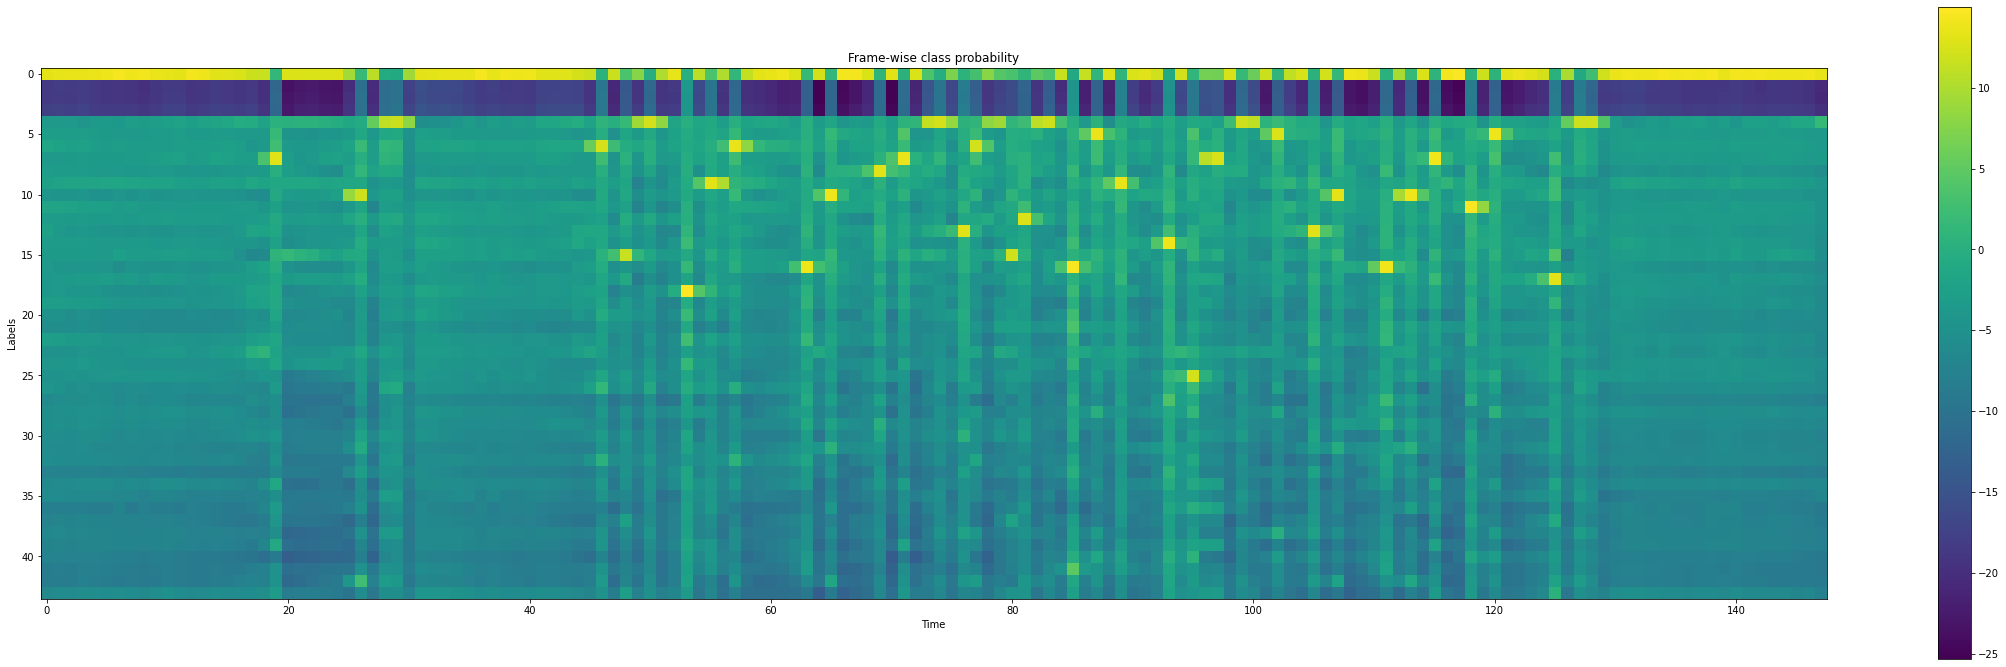

In [11]:
transcript = predicted[0].replace(' ', '|')
dictionary = processor.tokenizer.get_vocab()

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

# - - - -
plt.rcParams['figure.figsize'] = [40, 12]
plt.imshow(logits[0].cpu().detach().T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [12]:
pred_ids

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  7,  0,  0,  0,  0,  0,  0, 10,  0,  4,  4,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0, 15,  4,  4,  0,  0, 18,
          0,  9,  9,  6,  0,  0,  0,  0,  0, 16,  0, 10,  0,  0,  0,  8,  0,  7,
          0,  4,  4,  4, 13,  6,  4,  4, 15, 12,  4,  4,  0, 16,  0,  5,  0,  9,
          0,  0,  0, 14,  0, 25,  7,  7,  0,  4,  4,  0,  5,  0,  0, 13,  0, 10,
          0,  0,  0, 16,  0, 10,  0,  7,  0,  0, 11,  0,  5,  0,  0,  0,  0, 17,
          0,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]])

[('o', 7), ('i', 10), ('|', 4), ('e', 6), ('u', 15), ('|', 4), ('p', 18), ('r', 9), ('e', 6), ('c', 16), ('i', 10), ('s', 8), ('o', 7), ('|', 4), ('d', 13), ('e', 6), ('|', 4), ('u', 15), ('m', 12), ('|', 4), ('c', 16), ('a', 5), ('r', 9), ('t', 14), ('ã', 25), ('o', 7), ('|', 4), ('a', 5), ('d', 13), ('i', 10), ('c', 16), ('i', 10), ('o', 7), ('n', 11), ('a', 5), ('l', 17)]


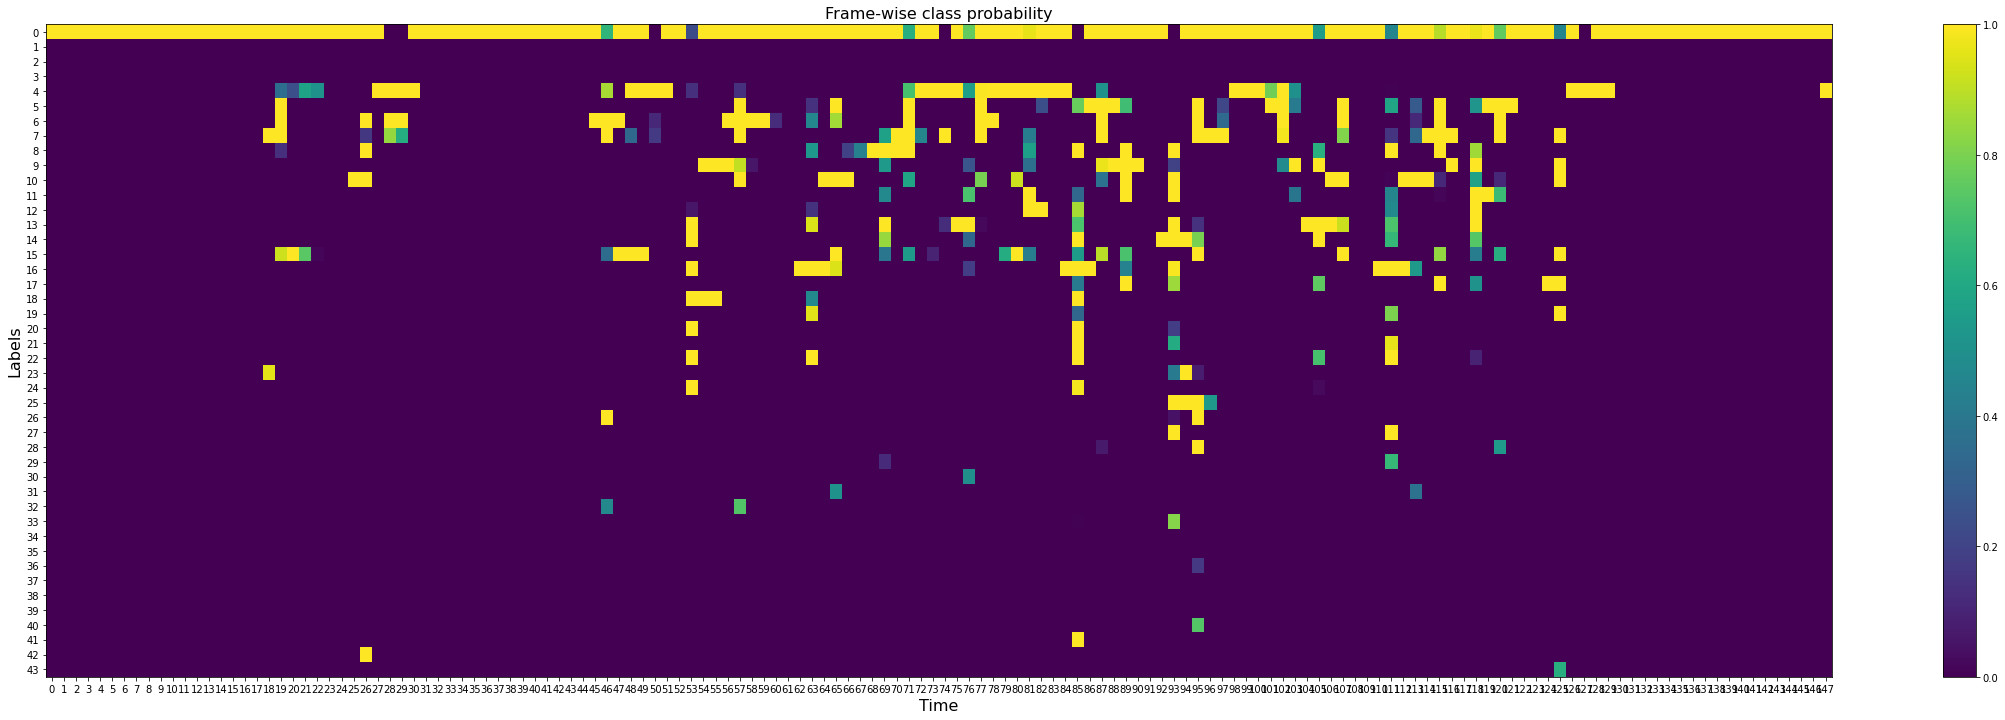

In [17]:
# Same fig normalized
print(list(zip(transcript, tokens)))
plt.rcParams['figure.figsize'] = [40, 12]
plt.imshow(logits[0].cpu().detach().T, vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.title("Frame-wise class probability", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.yticks(np.arange(logits.shape[-1]).tolist())
plt.xticks(np.arange(logits.shape[1]).tolist())
plt.ylabel("Labels", fontsize=16)
plt.savefig('logits_wav.png')
plt.show()


<img src="https://drive.google.com/uc?id=1Kjjg0OJpJoma8T1pQ650UcUgY85ge9Tz" />




In [14]:
processor.tokenizer.get_vocab()

{'-': 35,
 '</s>': 2,
 '<pad>': 0,
 '<s>': 1,
 '<unk>': 3,
 'a': 5,
 'b': 24,
 'c': 16,
 'd': 13,
 'e': 6,
 'f': 22,
 'g': 21,
 'h': 23,
 'i': 10,
 'j': 30,
 'k': 41,
 'l': 17,
 'm': 12,
 'n': 11,
 'o': 7,
 'p': 18,
 'q': 20,
 'r': 9,
 's': 8,
 't': 14,
 'u': 15,
 'v': 19,
 'w': 43,
 'x': 33,
 'y': 42,
 'z': 29,
 '|': 4,
 'à': 38,
 'á': 28,
 'â': 40,
 'ã': 25,
 'ç': 27,
 'é': 26,
 'ê': 32,
 'í': 31,
 'ó': 34,
 'ô': 39,
 'õ': 36,
 'ú': 37}